
<center>

#**Trabajo 1:** Modelo de riesgo de crédito

</center>
<center>

---
Fundamentos de Analitica


---
**Profesor:**

Juan David Ospina Arango

---
**Integrantes:**

Maria Camila Durango Munoz

Danilo Giraldo López

Cristian Jaramillo Herrera

Juan Felipe Usuga Villegas
</center>

**Objetivos:**

*   Crear y validar un modelo de probabilidad de incumplimiento para toda la base
*   Representar este modelo con una scorecard
*   Analicar cuales variables hacen más riesgosa a una persona
*   Crear una app web que le permita saber a las personas, de acuerdo con sus características, cuál es su scorecard y cómo se ve contra la población


## Librerías y carga de los datos

In [ ]:
!pip install --upgrade pip
!pip install pandas==1.5.3 seaborn==0.12.2 matplotlib==3.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.2 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
#Librerías para los datos en Google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
#Librerías para gráficos y procesamiento de los datos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#Librerias para modelos
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

In [ ]:
#La base de datos se encuentra en el siguiente link
#https://drive.google.com/file/d/1EiWIqkeH05a--49gO3UWjSiMstYE4A2g/view?usp=drive_link

In [ ]:
#tiene que autentificar con la misma cuenta que abrio el colab
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1EiWIqkeH05a--49gO3UWjSiMstYE4A2g'
#el id del link de arriba

download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('credit_risk_dataset.csv')
demoData  = pd.read_csv("credit_risk_dataset.csv").copy()

## Exploración de los datos

In [ ]:
print("La cantidad de filas que tenemos es:", demoData.shape[0],
      "\nY la cantidad de columnas es:", demoData.shape[1],
      "\n\nLas primeras columnas de nuestro data set nos arrojan la siguiente información:")

demoData.head()

La cantidad de filas que tenemos es: 32581 
Y la cantidad de columnas es: 12 

Las primeras columnas de nuestro data set nos arrojan la siguiente información:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
demoData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


Con lo anterior podemos darnos cuenta que tenemos varios datos faltantes en las siguientes columnas:

- person_emp_length = Duración del empleo (En años)
- loan_int_rate = Tasa de interes

In [ ]:
demoData.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

Aquí podemos denotar que el data set tiene los tipos de datos de forma correcta de acuerdo al nombre y descripción de las columnas.

In [ ]:
demoData.describe().round(1)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.0,32581.0,31686.0,32581.0,29465.0,32581.0,32581.0,32581.0
mean,27.7,66074.8,4.8,9589.4,11.0,0.2,0.2,5.8
std,6.3,61983.1,4.1,6322.1,3.2,0.4,0.1,4.1
min,20.0,4000.0,0.0,500.0,5.4,0.0,0.0,2.0
25%,23.0,38500.0,2.0,5000.0,7.9,0.0,0.1,3.0
50%,26.0,55000.0,4.0,8000.0,11.0,0.0,0.2,4.0
75%,30.0,79200.0,7.0,12200.0,13.5,0.0,0.2,8.0
max,144.0,6000000.0,123.0,35000.0,23.2,1.0,0.8,30.0


La tabla anterior la podemos utilizar para identificar valores extraños, por ejemplo en la columna edad, tenemos un valor minimo de edad igual a 20, una media de edad de 27 años y por otro lado tenemos un valor máximo de edad igual a 144, esto no es demasiado lógico así que por ejemplo se trata de valores que podemos eliminar del dataset ya que puede afectar el funcionamiento final del modelo.

In [ ]:
demoData = demoData[demoData['person_age'] <= 120]

Dejamos en el dataset exclusivamente personas con una edad inferior a 120 años, esto debido a que la persona viva más longeva actualmente es [Maria Branyas Morera](https://es.wikipedia.org/wiki/Anexo:Personas_vivas_m%C3%A1s_ancianas#:~:text=Desde%20la%20muerte%20de%20la,116%20a%C3%B1os%20y%20180%20d%C3%ADas.)

In [ ]:
# Validación de valores nulos
null = demoData.isnull().sum()
nullTable = pd.DataFrame({'Columna': demoData.columns, 'Valores nulos': null})
nullTable = nullTable.reset_index(drop=True)
nullTable

,Columna,Valores nulos
0,person_age,0
1,person_income,0
2,person_home_ownership,0
3,person_emp_length,895
4,loan_intent,0
5,loan_grade,0
6,loan_amnt,0
7,loan_int_rate,3115
8,loan_status,0
9,loan_percent_income,0


Como ya mencionamos anteriormente las columnas de Duración del empleo (En años) y Tasa de interes tienen valores nulos, ambos son valores a tener en cuenta en el modelo así que es importante contar con ellos, por lo tanto vamos a eliminar del dataset cualquier registro que no tenega valor en estos campos.

In [ ]:
demoData = demoData[demoData['person_emp_length'].isnull() != True]
demoData = demoData[demoData['loan_int_rate'].isnull() != True]

In [ ]:
# Validación de duplicados
duplicates = demoData.duplicated().sum()
duplicatesTable = pd.DataFrame({'Columna': demoData.columns, 'Duplicados': duplicates})
duplicatesTable

,Columna,Duplicados
0,person_age,137
1,person_income,137
2,person_home_ownership,137
3,person_emp_length,137
4,loan_intent,137
5,loan_grade,137
6,loan_amnt,137
7,loan_int_rate,137
8,loan_status,137
9,loan_percent_income,137


Cómo podemos ver tenemos valores duplicados que eliminaremos en la siguiente celda.

In [ ]:
demoData = demoData.drop_duplicates()

Ahora vamos a validar nuevamente que ya no tengamos valores atipicos como edades fuera de rango, valores nulos ni valores duplicados.

In [ ]:
demoData.describe().round(1)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,28497.0,28497.0,28497.0,28497.0,28497.0,28497.0,28497.0,28497.0
mean,27.7,66434.6,4.8,9658.6,11.0,0.2,0.2,5.8
std,6.2,51517.3,4.2,6329.6,3.2,0.4,0.1,4.0
min,20.0,4000.0,0.0,500.0,5.4,0.0,0.0,2.0
25%,23.0,39480.0,2.0,5000.0,7.9,0.0,0.1,3.0
50%,26.0,56000.0,4.0,8000.0,11.0,0.0,0.2,4.0
75%,30.0,80000.0,7.0,12500.0,13.5,0.0,0.2,8.0
max,84.0,2039784.0,123.0,35000.0,23.2,1.0,0.8,30.0


In [ ]:
null = demoData.isnull().sum()
nullTable = pd.DataFrame({'Columna': demoData.columns, 'Valores nulos': null})
nullTable = nullTable.reset_index(drop=True)
nullTable

,Columna,Valores nulos
0,person_age,0
1,person_income,0
2,person_home_ownership,0
3,person_emp_length,0
4,loan_intent,0
5,loan_grade,0
6,loan_amnt,0
7,loan_int_rate,0
8,loan_status,0
9,loan_percent_income,0


In [ ]:
duplicates = demoData.duplicated().sum()
duplicatesTable = pd.DataFrame({'Columna': demoData.columns, 'Duplicados': duplicates})
duplicatesTable

,Columna,Duplicados
0,person_age,0
1,person_income,0
2,person_home_ownership,0
3,person_emp_length,0
4,loan_intent,0
5,loan_grade,0
6,loan_amnt,0
7,loan_int_rate,0
8,loan_status,0
9,loan_percent_income,0


Para la columna "cb_person_default_on_file" tenemos una columna binaria así que vamos a asignarle un valor de 0 o 1:

In [ ]:
unique_values = demoData['cb_person_default_on_file'].unique()
print(unique_values)

['Y' 'N']


In [ ]:
demoData['cb_person_default_on_file_encoded'] = demoData['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})
demoData['cb_person_default_on_file_encoded'].value_counts(normalize = True)

<ipython-input-18-ff447df06c06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demoData['cb_person_default_on_file_encoded'] = demoData['cb_person_default_on_file'].replace({'Y': 1, 'N': 0})


0    0.821385
1    0.178615
Name: cb_person_default_on_file_encoded, dtype: float64

In [ ]:
demoData = demoData.drop(['cb_person_default_on_file'], axis=1)
demoData

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_encoded
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,3,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,2,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,28,0
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,26,0


Teniendo los diccionarios de nuestras variables categoricas podemos empezar a eliminar las columnas originales.

Ahora que tenemos nuestra data tratada vamos a entregar un archivo csv listo para ser utilizado.

In [ ]:
demoData.to_csv('dataTratada.csv', index=False)

In [ ]:
df  = pd.read_csv("dataTratada.csv").copy()

In [ ]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_encoded
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,3,0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,2,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
28492,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,30,0
28493,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,19,0
28494,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,28,0
28495,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,26,0


In [ ]:
# Dividir los datos en 80/20 manteniendo la distribución de préstamos incobrables en el conjunto de prueba igual que en el conjunto de datos previo a la división
X = df.drop('loan_status', axis = 1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    random_state = 42, stratify = y)

X_train, X_test = X_train.copy(), X_test.copy()

## Feature Selection

A continuación, realizaremos la selección de características para identificar las más adecuadas para nuestro problema de clasificación binaria utilizando la prueba de Chi-cuadrado para las características categóricas y el estadístico F de ANOVA para las características numéricas.

In [ ]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

Estadística Chi-squared para Variables categoricas

In [ ]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result


,Feature,p-value
0,person_home_ownership,0.0
1,loan_intent,0.0
2,loan_grade,0.0


ANOVA F-Statistic para variables numericas

In [ ]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,loan_percent_income,3841.069495,0.000000
1,loan_int_rate,3012.129322,0.000000
2,cb_person_default_on_file_encoded,800.482236,0.000000
3,person_income,666.867244,0.000000
4,loan_amnt,286.208024,0.000000
5,person_emp_length,164.330917,0.000000
6,person_age,12.265920,0.000462
7,cb_person_cred_hist_length,3.501443,0.061328


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

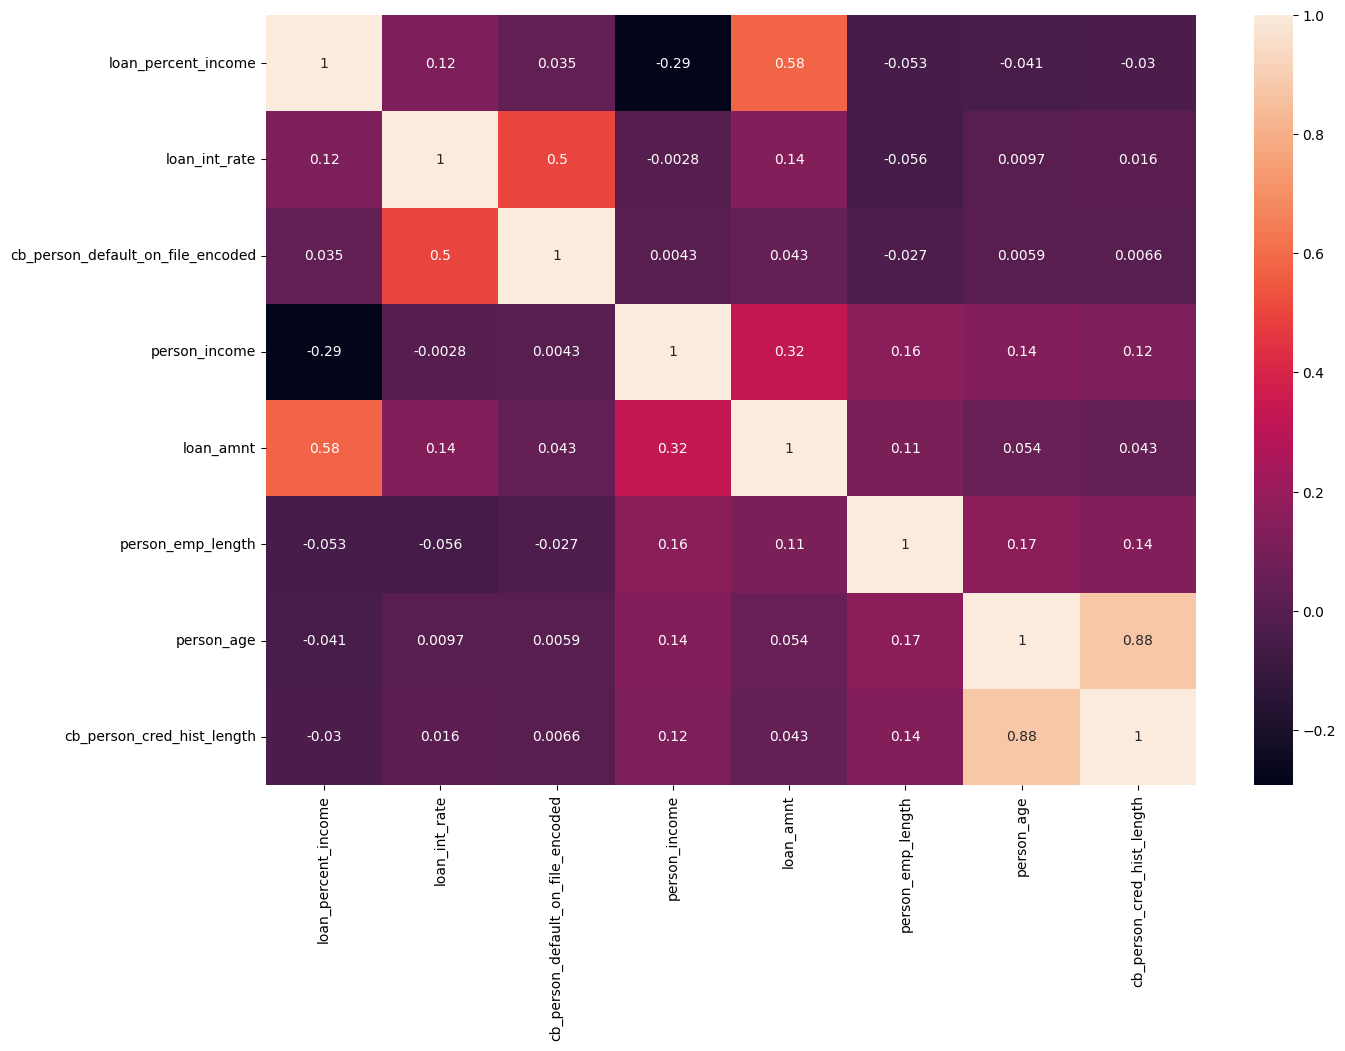

In [ ]:
# save the top 16 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:16,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(15,10))
sns.heatmap(corrmat, annot=True)
plt.savefig('heatmap.png')
from google.colab import files
files.download("heatmap.png") ;

In [ ]:
#Se elimina la variable con alta correlacion y con p-value mayor al alfa 0.05
X_train=X_train.drop(['cb_person_cred_hist_length'], axis=1)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22797 entries, 22544 to 22997
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         22797 non-null  int64  
 1   person_income                      22797 non-null  int64  
 2   person_home_ownership              22797 non-null  object 
 3   person_emp_length                  22797 non-null  float64
 4   loan_intent                        22797 non-null  object 
 5   loan_grade                         22797 non-null  object 
 6   loan_amnt                          22797 non-null  int64  
 7   loan_int_rate                      22797 non-null  float64
 8   loan_percent_income                22797 non-null  float64
 9   cb_person_default_on_file_encoded  22797 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 1.9+ MB


In [ ]:
pd.DataFrame(X_train.dtypes)

,0
person_age,int64
person_income,int64
person_home_ownership,object
person_emp_length,float64
loan_intent,object
loan_grade,object
loan_amnt,int64
loan_int_rate,float64
loan_percent_income,float64
cb_person_default_on_file_encoded,int64


## One-Hot Encoding y actualización de los datos de prueba

Para las variables categoricas

### Dummy variables

In [ ]:
# Funcion para la creacion de variables dummy
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# Aplicando la funcion para nuestras variables categoricas
X_train = dummy_creation(X_train, [ 'person_home_ownership', 'loan_intent', 'loan_grade'])


### Actualizacion de los datos de prueba

In [ ]:
#Actualizacion de los datos de prueba
X_test=X_test.drop(['cb_person_cred_hist_length'], axis=1)
X_test = dummy_creation(X_test,[ 'person_home_ownership', 'loan_intent', 'loan_grade'])
# reindexar las variables del conjunto de pruebas con variables ficticias para
#asegurarse de que todas las columnas de características en el conjunto de entrenamiento también estén disponibles en el conjunto de pruebas
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22797 entries, 22544 to 22997
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_age                         22797 non-null  int64  
 1   person_income                      22797 non-null  int64  
 2   person_home_ownership              22797 non-null  object 
 3   person_emp_length                  22797 non-null  float64
 4   loan_intent                        22797 non-null  object 
 5   loan_grade                         22797 non-null  object 
 6   loan_amnt                          22797 non-null  int64  
 7   loan_int_rate                      22797 non-null  float64
 8   loan_percent_income                22797 non-null  float64
 9   cb_person_default_on_file_encoded  22797 non-null  int64  
 10  person_home_ownership:MORTGAGE     22797 non-null  uint8  
 11  person_home_ownership:OTHER        22797 non-null 

## WoE Binning and Feature Engineering

### Análisis del WoEs y IVs de variables discretas

In [ ]:
# Crear copias de los 4 conjuntos de entrenamiento para ser preprocesados usando la técnica de WoE (Weight of Evidence)
X_train_prepr = X_train.copy()
y_train_prepr = y_train.copy()
X_test_prepr = X_test.copy()
y_test_prepr = y_test.copy()

# Función para calcular WoE (Peso de la Evidencia) y IV (Valor de la Información) de características categóricas
# La función toma 3 argumentos: un DataFrame (X_train_prepr), una cadena de texto (nombre de la columna) y otro DataFrame (y_train_prepr).
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [ ]:
# Establecemos el estilo predeterminado de los gráficos al estilo de seaborn.
sns.set()
# A continuación, definimos una función para trazar el WoE (Peso de la Evidencia) entre categorías que toma 2 argumentos: un DataFrame y un número.
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

**"person_home_ownership"**

In [ ]:
df_temp = woe_discrete(X_train_prepr, 'person_home_ownership', y_train_prepr)
df_temp

,person_home_ownership,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,OWN,1744,0.062500,0.076501,109.0,1635.0,0.022020,0.091612,-1.425602,NaN,NaN,0.383001
1,MORTGAGE,9354,0.126684,0.410317,1185.0,8169.0,0.239394,0.457724,-0.648156,0.064184,0.777446,0.383001
2,OTHER,79,0.291139,0.003465,23.0,56.0,0.004646,0.003138,0.392590,0.164455,1.040746,0.383001
3,RENT,11620,0.312651,0.509716,3633.0,7987.0,0.733939,0.447526,0.494691,0.021511,0.102101,0.383001


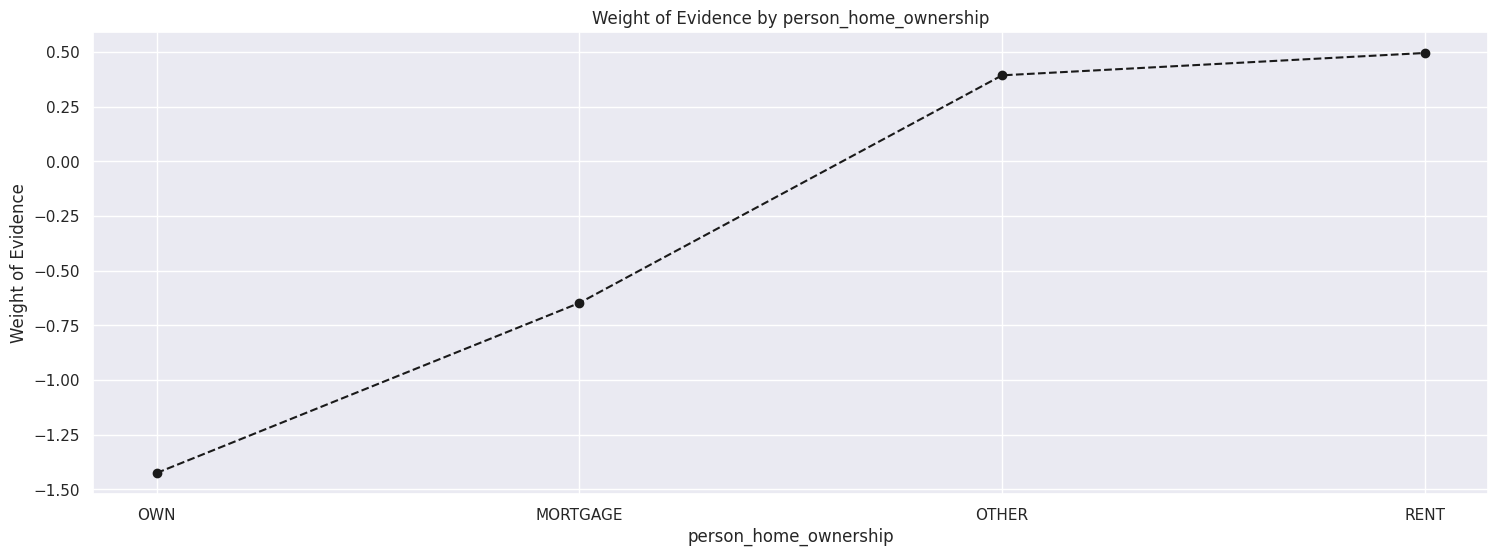

In [ ]:
plot_by_woe(df_temp)

**"loan_intent"**

In [ ]:
df_temp = woe_discrete(X_train_prepr, 'loan_intent', y_train_prepr)
df_temp

,loan_intent,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,VENTURE,3961,0.141126,0.173751,559.0,3402.0,0.112929,0.190620,-0.523521,NaN,NaN,0.10538
1,EDUCATION,4544,0.169014,0.199324,768.0,3776.0,0.155152,0.211576,-0.310183,0.027888,0.213339,0.10538
2,PERSONAL,3876,0.202270,0.170022,784.0,3092.0,0.158384,0.173250,-0.089717,0.033256,0.220466,0.10538
3,HOMEIMPROVEMENT,2566,0.259938,0.112559,667.0,1899.0,0.134747,0.106404,0.236155,0.057667,0.325872,0.10538
4,MEDICAL,4197,0.270670,0.184103,1136.0,3061.0,0.229495,0.171513,0.291220,0.010732,0.055064,0.10538
5,DEBTCONSOLIDATION,3653,0.283603,0.160240,1036.0,2617.0,0.209293,0.146635,0.355786,0.012933,0.064567,0.10538


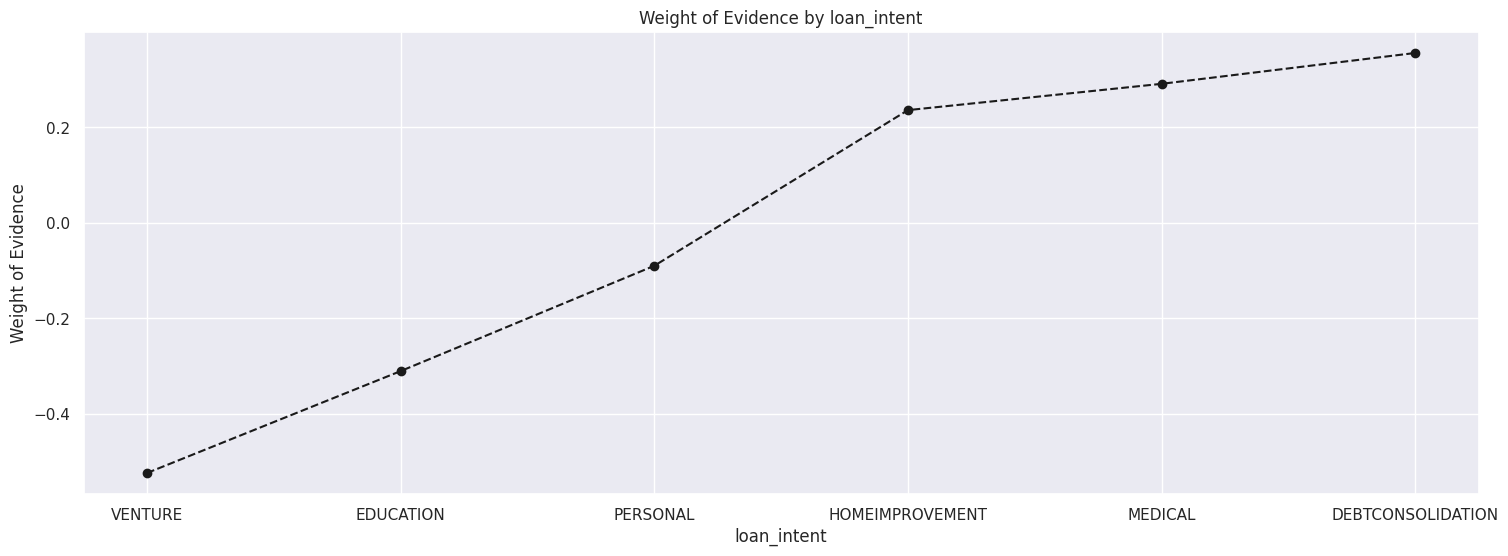

In [ ]:
plot_by_woe(df_temp)

In [ ]:
df_temp = woe_discrete(X_train_prepr, 'loan_grade', y_train_prepr)
df_temp

,loan_grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,A,7528,0.096971,0.330219,730.0,6798.0,0.147475,0.380904,-0.948891,NaN,NaN,0.935977
1,B,7219,0.157085,0.316664,1134.0,6085.0,0.229091,0.340954,-0.397628,0.060114,0.551264,0.935977
2,C,4514,0.201374,0.198009,909.0,3605.0,0.183636,0.201995,-0.095284,0.044288,0.302344,0.935977
3,D,2601,0.595540,0.114094,1549.0,1052.0,0.312929,0.058945,1.669364,0.394167,1.764648,0.935977
4,E,710,0.646479,0.031144,459.0,251.0,0.092727,0.014064,1.886045,0.050939,0.216681,0.935977
5,F,173,0.682081,0.007589,118.0,55.0,0.023838,0.003082,2.045799,0.035602,0.159754,0.935977
6,G,52,0.980769,0.002281,51.0,1.0,0.010303,0.000056,5.214273,0.298688,3.168474,0.935977


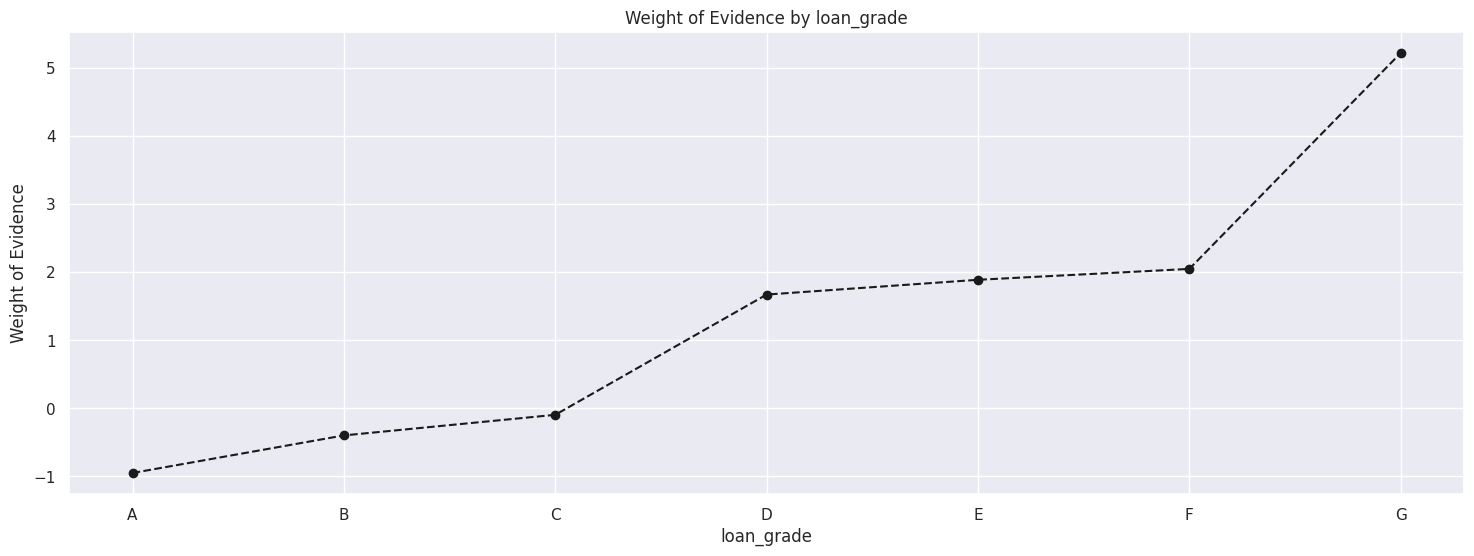

In [ ]:
plot_by_woe(df_temp)

**loan_intent**

### Análisis del WoEs y IVs de variables numericas

In [ ]:
'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df


**"person_age"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['person_age_factor'] = pd.cut(X_train_prepr['person_age'],4)
df_temp = woe_ordered_continuous(X_train_prepr, 'person_age_factor', y_train_prepr)
df_temp

,person_age_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(19.936, 36.0]",20817,0.218571,0.913146,4550.0,16267.0,0.919192,0.911470,0.008437,NaN,NaN,0.002486
1,"(36.0, 52.0]",1839,0.197390,0.080669,363.0,1476.0,0.073333,0.082703,-0.120240,0.021181,0.128677,0.002486
2,"(52.0, 68.0]",128,0.281250,0.005615,36.0,92.0,0.007273,0.005155,0.344178,0.083860,0.464419,0.002486
3,"(68.0, 84.0]",13,0.076923,0.000570,1.0,12.0,0.000202,0.000672,-1.202459,0.204327,1.546637,0.002486


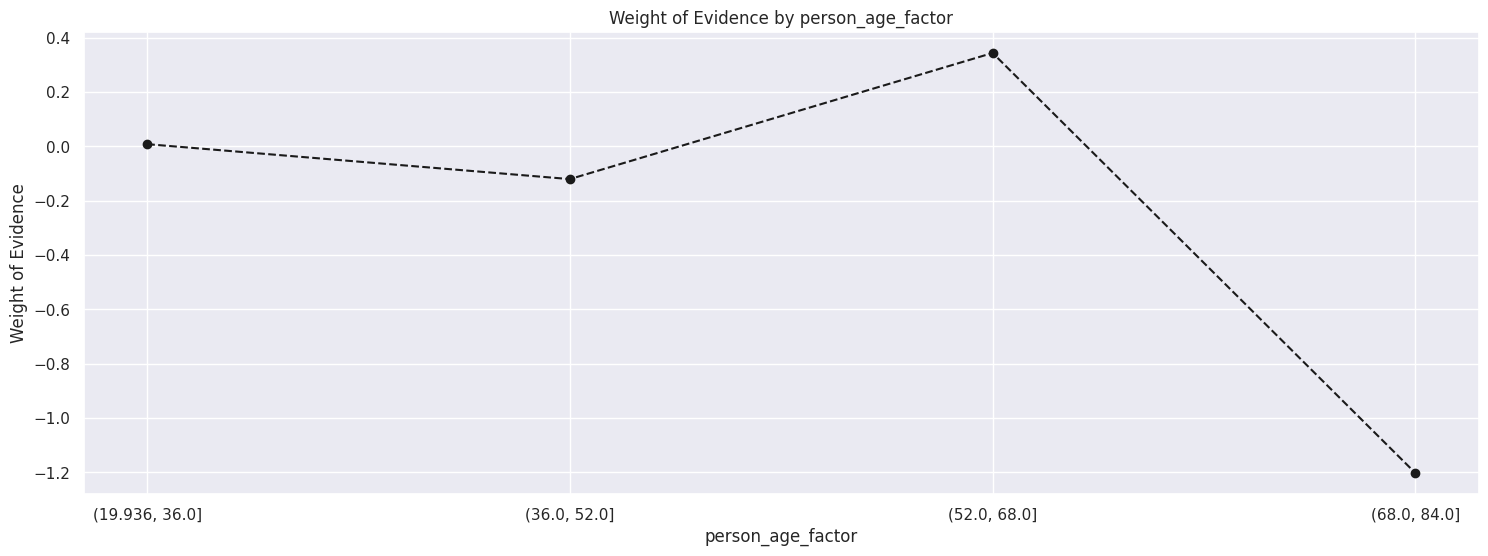

In [ ]:
plot_by_woe(df_temp)

**"person_income"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['person_income_factor'] = pd.cut(X_train_prepr['person_income'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'person_income_factor', y_train_prepr)
df_temp

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,person_income_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(2044.296, 411220.8]",22749,0.217372,0.997894,4945.0,17804.0,0.99899,0.997591,0.001402,NaN,NaN,inf
1,"(411220.8, 818361.6]",40,0.125000,0.001755,5.0,35.0,0.00101,0.001961,-0.663462,0.092372,0.664864,inf
2,"(818361.6, 1225502.4]",4,0.000000,0.000175,0.0,4.0,0.00000,0.000224,-inf,0.125000,inf,inf
3,"(1225502.4, 1632643.2]",2,0.000000,0.000088,0.0,2.0,0.00000,0.000112,-inf,0.000000,NaN,inf
4,"(1632643.2, 2039784.0]",2,0.000000,0.000088,0.0,2.0,0.00000,0.000112,-inf,0.000000,NaN,inf


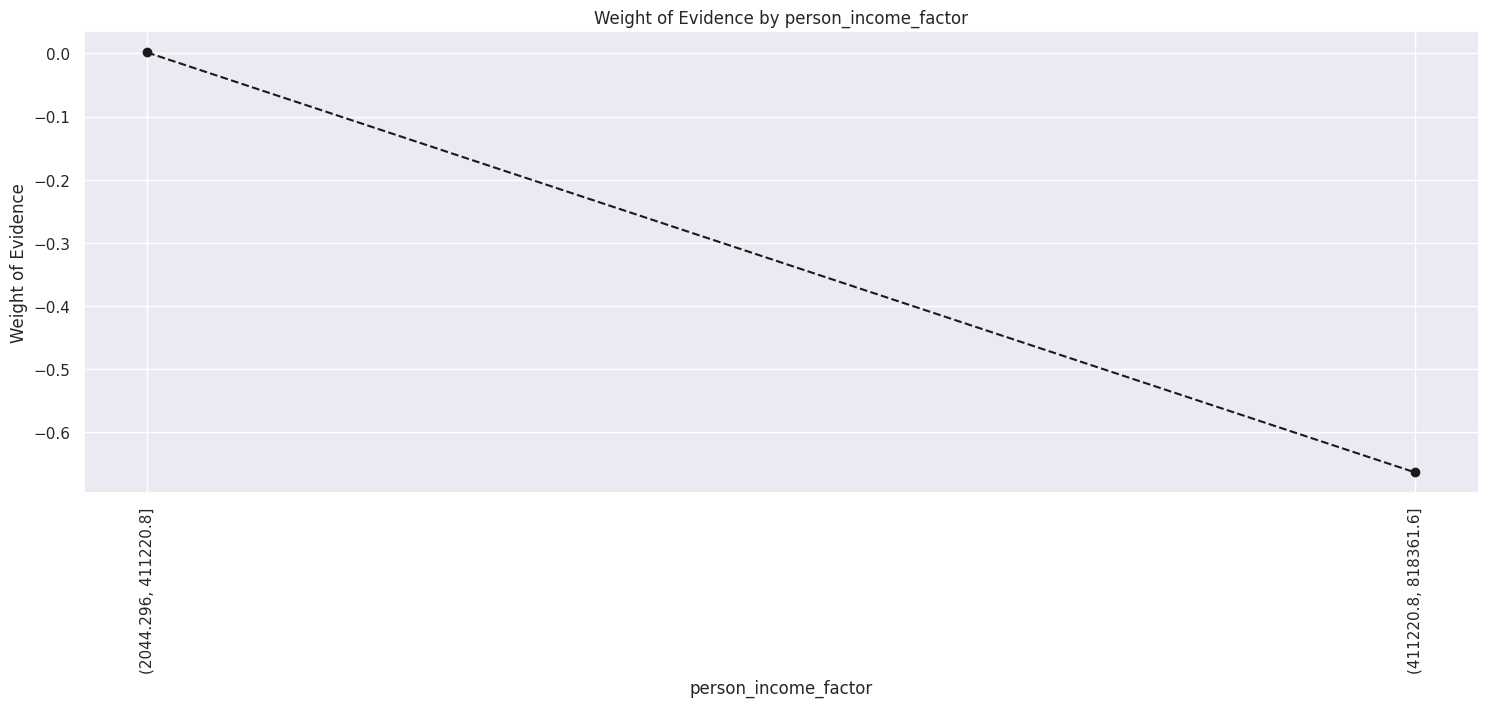

In [ ]:
plot_by_woe(df_temp, 90)

Se eliminan los 8 datos atipicos que dificultan los intervalos

In [ ]:
X_train_prepr = X_train_prepr[X_train_prepr['person_income'] < 818361.6]

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['person_income_factor'] = pd.cut(X_train_prepr['person_income'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'person_income_factor', y_train_prepr)
df_temp

<ipython-input-48-08387499ba04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_prepr['person_income_factor'] = pd.cut(X_train_prepr['person_income'], 5)


,person_income_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(3284.08, 163264.0]",22172,0.220639,0.972926,4892.0,17280.0,0.988283,0.968664,0.020051,NaN,NaN,0.020425
1,"(163264.0, 322448.0]",544,0.093750,0.023871,51.0,493.0,0.010303,0.027636,-0.986684,0.126889,1.006735,0.020425
2,"(322448.0, 481632.0]",48,0.062500,0.002106,3.0,45.0,0.000606,0.002523,-1.426051,0.031250,0.439367,0.020425
3,"(481632.0, 640816.0]",15,0.133333,0.000658,2.0,13.0,0.000404,0.000729,-0.589803,0.070833,0.836248,0.020425
4,"(640816.0, 800000.0]",10,0.200000,0.000439,2.0,8.0,0.000404,0.000448,-0.104295,0.066667,0.485508,0.020425


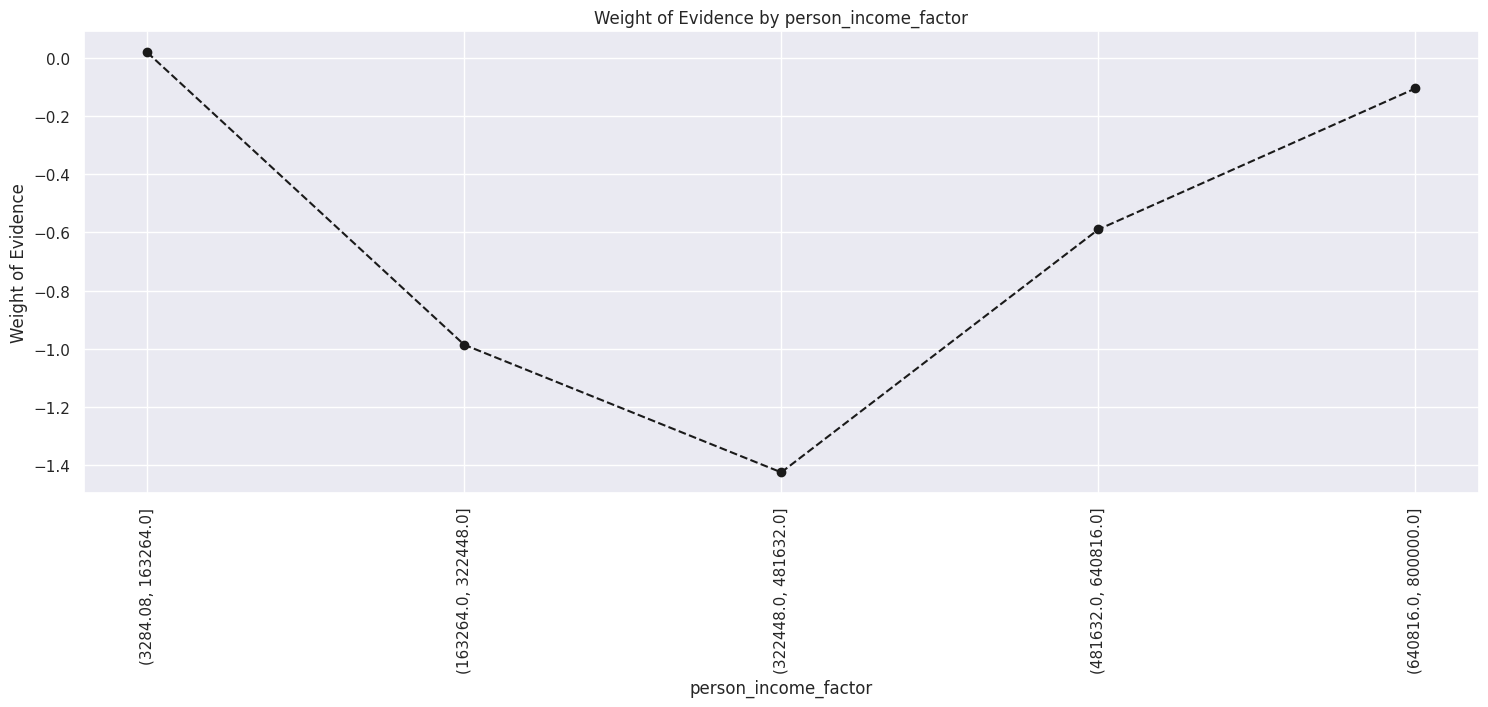

In [ ]:
plot_by_woe(df_temp, 90)

**"person_emp_length"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['person_emp_length_factor'] = pd.cut(X_train_prepr['person_emp_length'], 2)
df_temp = woe_ordered_continuous(X_train_prepr, 'person_emp_length_factor', y_train_prepr)
df_temp

,person_emp_length_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.123, 61.5]",22787,0.217185,0.999912,4949.0,17838.0,0.999798,0.999944,-0.000146,NaN,NaN,0.000187
1,"(61.5, 123.0]",2,0.500000,0.000088,1.0,1.0,0.000202,0.000056,1.281999,0.282815,1.282145,0.000187


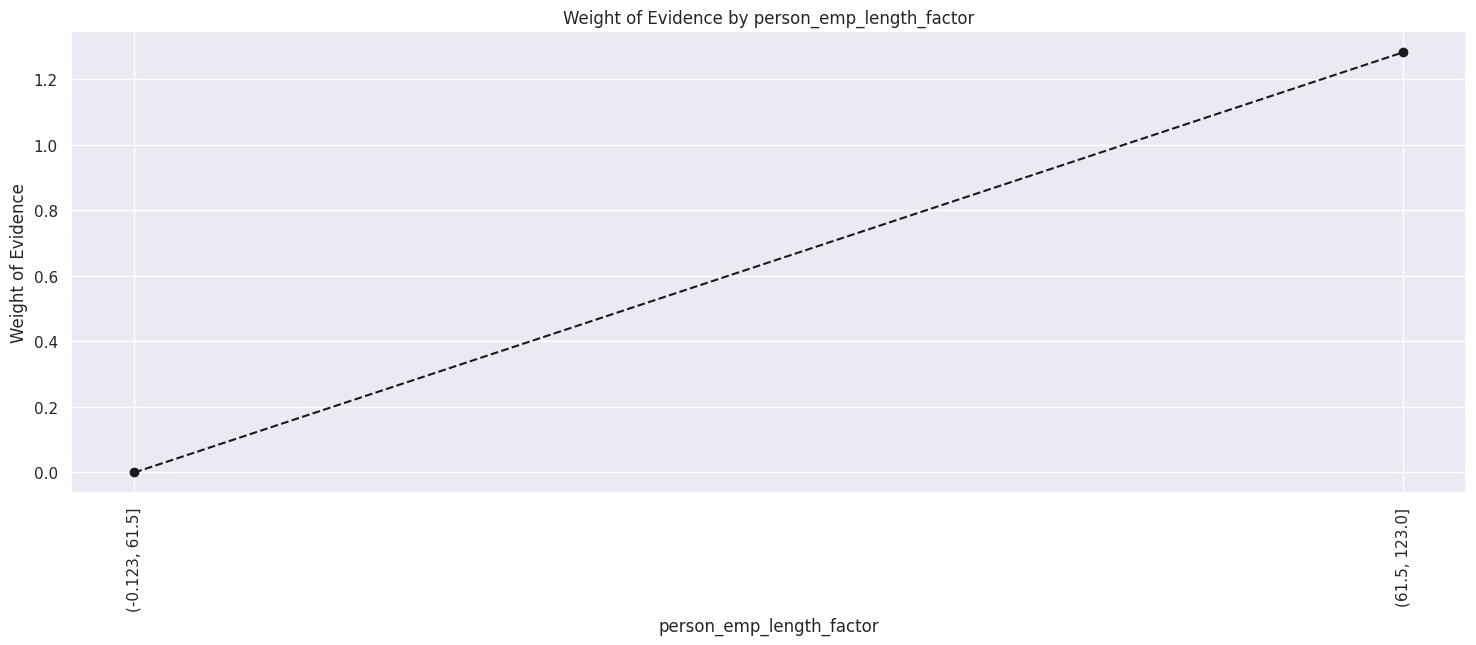

In [ ]:
plot_by_woe(df_temp, 90)

Quitamos los datos atipicos, evidenciamos que empiezan desde los 32.8 años

In [ ]:
X_train_prepr = X_train_prepr[X_train_prepr['person_emp_length'] < 32.8]

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['person_emp_length_factor'] = pd.cut(X_train_prepr['person_emp_length'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'person_emp_length_factor', y_train_prepr)
df_temp

<ipython-input-53-6577d4dacd25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_prepr['person_emp_length_factor'] = pd.cut(X_train_prepr['person_emp_length'], 5)


,person_emp_length_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.031, 6.2]",16449,0.234665,0.721891,3860.0,12589.0,0.779956,0.705780,0.099933,NaN,NaN,0.031922
1,"(6.2, 12.4]",5179,0.175903,0.227289,911.0,4268.0,0.184078,0.239278,-0.262268,0.058762,0.362201,0.031922
2,"(12.4, 18.6]",1010,0.148515,0.044325,150.0,860.0,0.030309,0.048214,-0.464208,0.027388,0.201939,0.031922
3,"(18.6, 24.8]",126,0.214286,0.005530,27.0,99.0,0.005456,0.005550,-0.017194,0.065771,0.447014,0.031922
4,"(24.8, 31.0]",22,0.045455,0.000966,1.0,21.0,0.000202,0.001177,-1.762433,0.168831,1.745239,0.031922


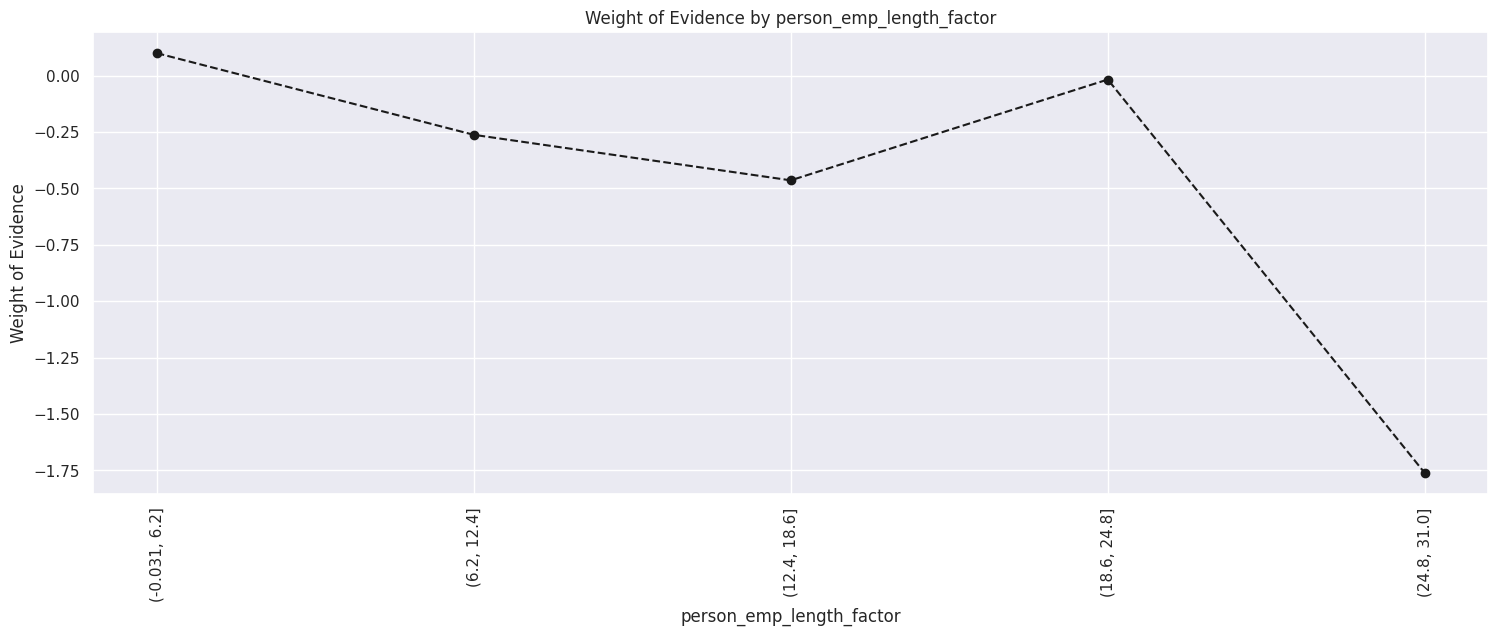

In [ ]:
plot_by_woe(df_temp, 90)

**"loan_amnt"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['loan_amnt_factor'] = pd.cut(X_train_prepr['loan_amnt'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'loan_amnt_factor', y_train_prepr)
df_temp

,loan_amnt_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(465.5, 7400.0]",10118,0.183534,0.444045,1857.0,8261.0,0.375227,0.463138,-0.210494,NaN,NaN,0.07685
1,"(7400.0, 14300.0]",7947,0.206871,0.348767,1644.0,6303.0,0.332188,0.353367,-0.061804,0.023336,0.148690,0.07685
2,"(14300.0, 21200.0]",3363,0.284865,0.147591,958.0,2405.0,0.193574,0.134832,0.361632,0.077994,0.423436,0.07685
3,"(21200.0, 28100.0]",1124,0.362989,0.049329,408.0,716.0,0.082441,0.040141,0.719676,0.078125,0.358044,0.07685
4,"(28100.0, 35000.0]",234,0.350427,0.010269,82.0,152.0,0.016569,0.008522,0.664928,0.012562,0.054748,0.07685


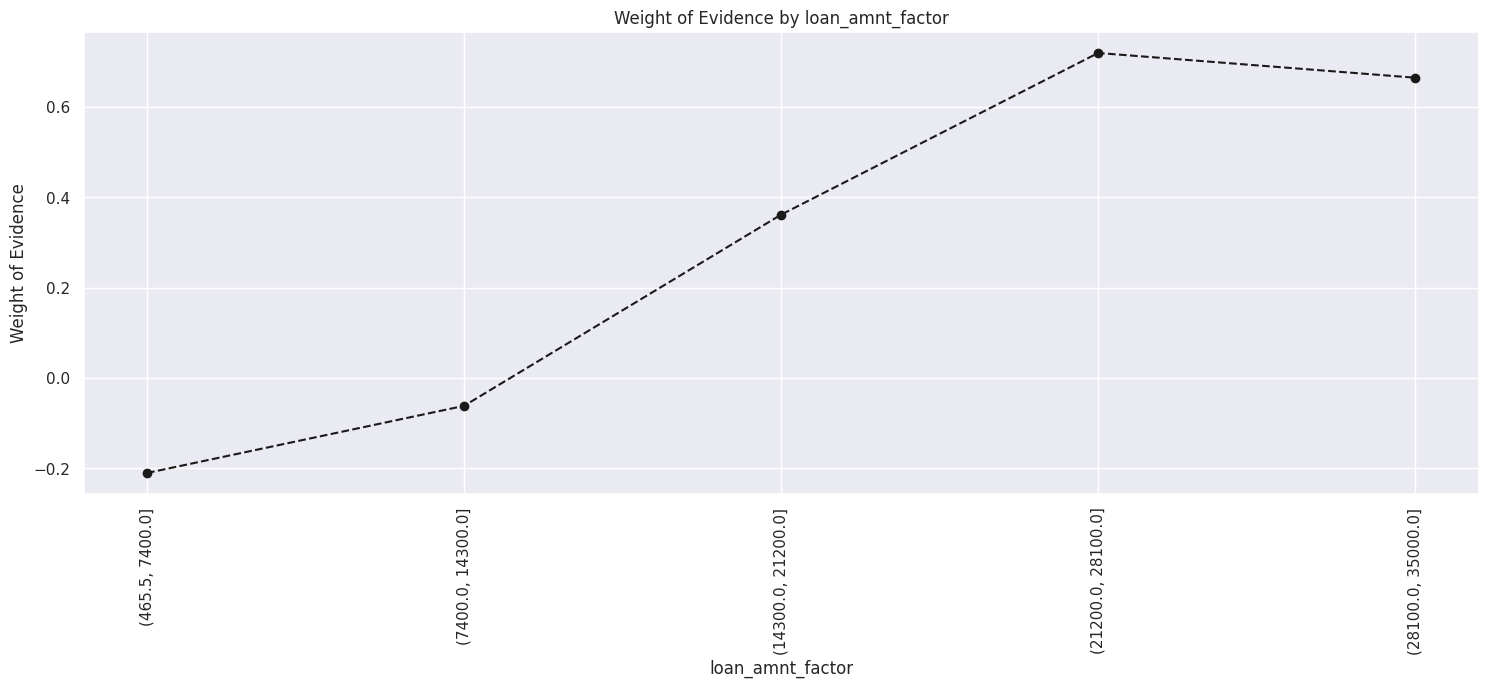

In [ ]:
plot_by_woe(df_temp, 90)

**"loan_int_rate"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['loan_int_rate_factor'] = pd.cut(X_train_prepr['loan_int_rate'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'loan_int_rate_factor', y_train_prepr)
df_temp

,loan_int_rate_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(5.402, 8.98]",7296,0.097177,0.320197,709.0,6587.0,0.143261,0.369289,-0.946908,NaN,NaN,0.640026
1,"(8.98, 12.54]",7779,0.160303,0.341394,1247.0,6532.0,0.251970,0.366205,-0.373883,0.063127,0.573025,0.640026
2,"(12.54, 16.1]",6385,0.338763,0.280216,2163.0,4222.0,0.437058,0.236699,0.613277,0.178459,0.987160,0.640026
3,"(16.1, 19.66]",1239,0.610169,0.054375,756.0,483.0,0.152758,0.027079,1.730114,0.271407,1.116838,0.640026
4,"(19.66, 23.22]",87,0.850575,0.003818,74.0,13.0,0.014953,0.000729,3.021205,0.240405,1.291091,0.640026


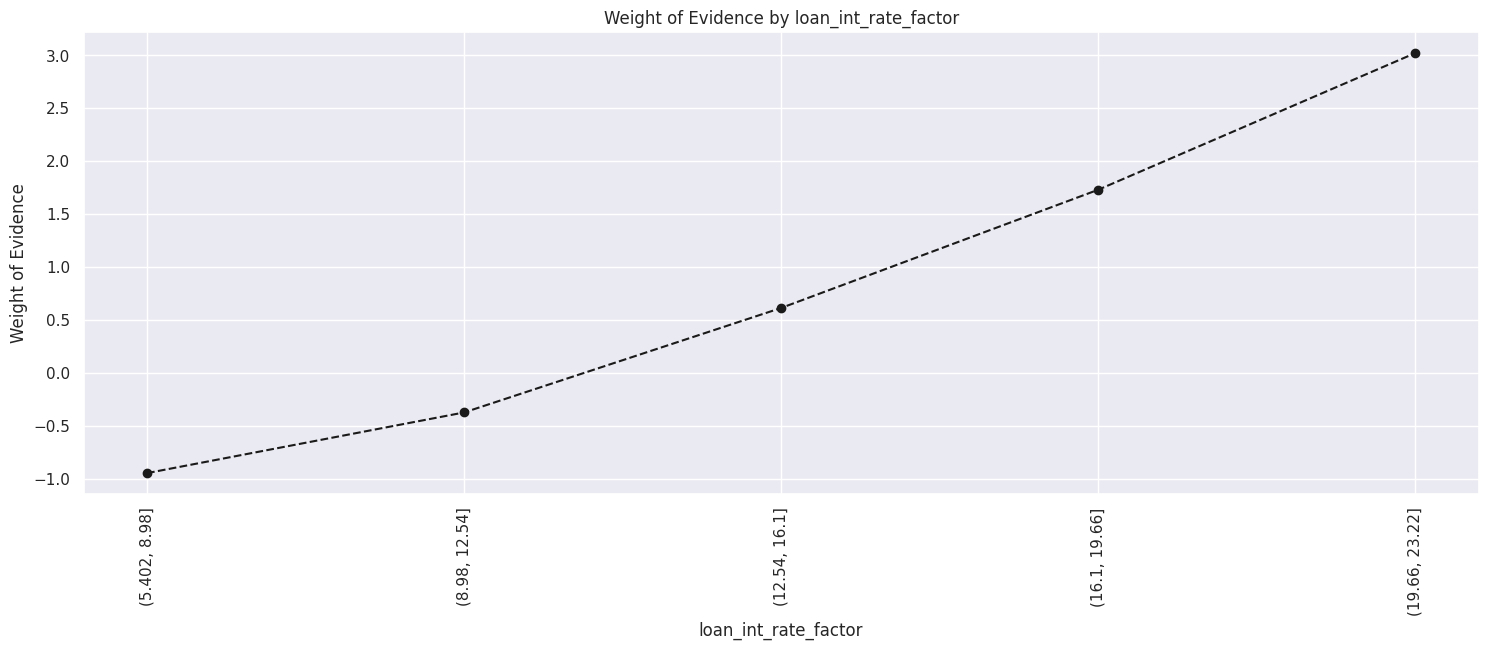

In [ ]:
plot_by_woe(df_temp, 90)

**"loan_percent_income"**

In [ ]:
# Discretización detallada utilizando el método 'cut', dada la gran cantidad de valores únicos
X_train_prepr['loan_percent_income_factor'] = pd.cut(X_train_prepr['loan_percent_income'], 5)
df_temp = woe_ordered_continuous(X_train_prepr, 'loan_percent_income_factor', y_train_prepr)
df_temp

,loan_percent_income_factor,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,"(-0.00083, 0.166]",12933,0.125648,0.567585,1625.0,11308.0,0.328349,0.633963,-0.657913,NaN,NaN,0.743746
1,"(0.166, 0.332]",7993,0.249343,0.350786,1993.0,6000.0,0.402708,0.336379,0.179971,0.123696,0.837884,0.743746
2,"(0.332, 0.498]",1625,0.705231,0.071316,1146.0,479.0,0.231562,0.026854,2.154422,0.455888,1.974451,0.743746
3,"(0.498, 0.664]",217,0.783410,0.009523,170.0,47.0,0.034350,0.002635,2.567740,0.078179,0.413319,0.743746
4,"(0.664, 0.83]",18,0.833333,0.000790,15.0,3.0,0.003031,0.000168,2.891527,0.049923,0.323787,0.743746


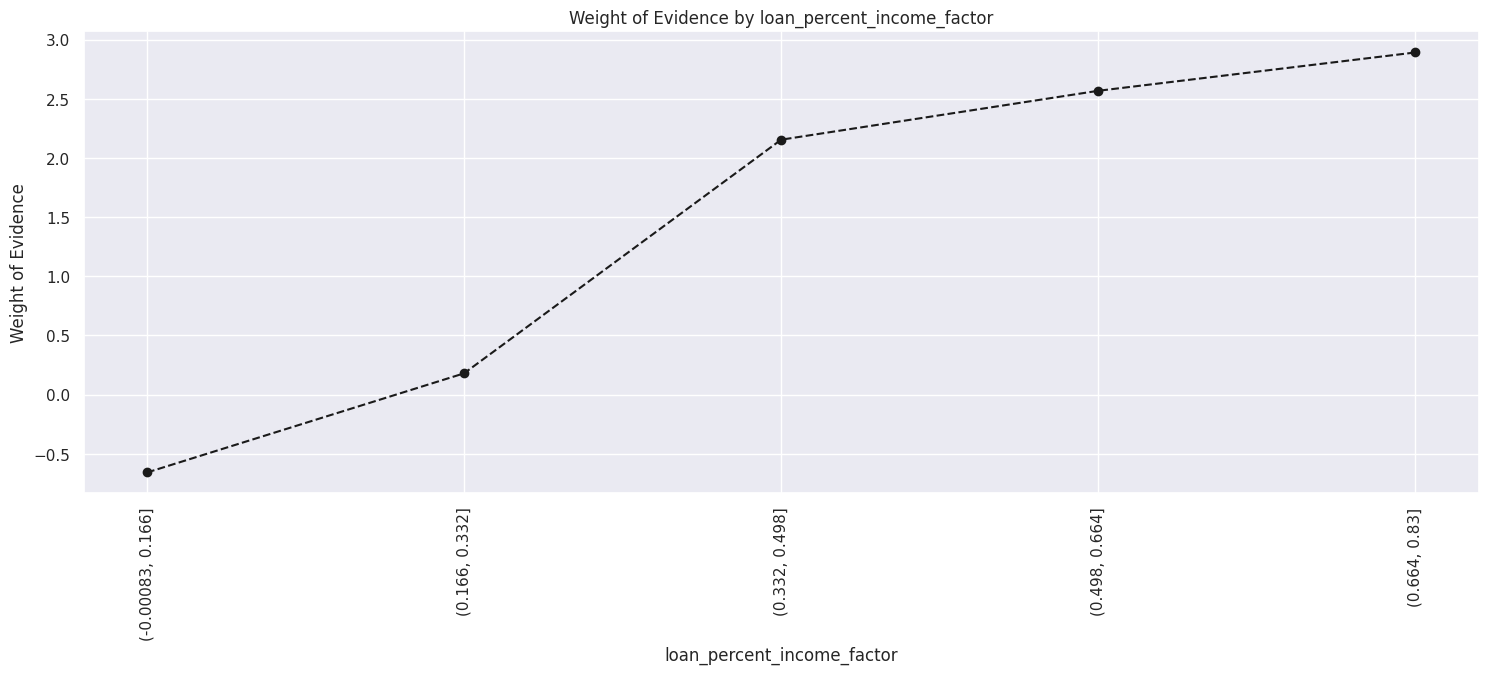

In [ ]:
plot_by_woe(df_temp, 90)

**"cb_person_default_on_file_encoded"**

In [ ]:
df_temp = woe_ordered_continuous(X_train_prepr, 'cb_person_default_on_file_encoded', y_train_prepr)
df_temp

,cb_person_default_on_file_encoded,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,18750,0.181973,0.822874,3412.0,15338.0,0.689432,0.859898,-0.220945,NaN,NaN,0.17336
1,1.0,4036,0.380823,0.177126,1537.0,2499.0,0.310568,0.140102,0.796031,0.198849,1.016977,0.17336


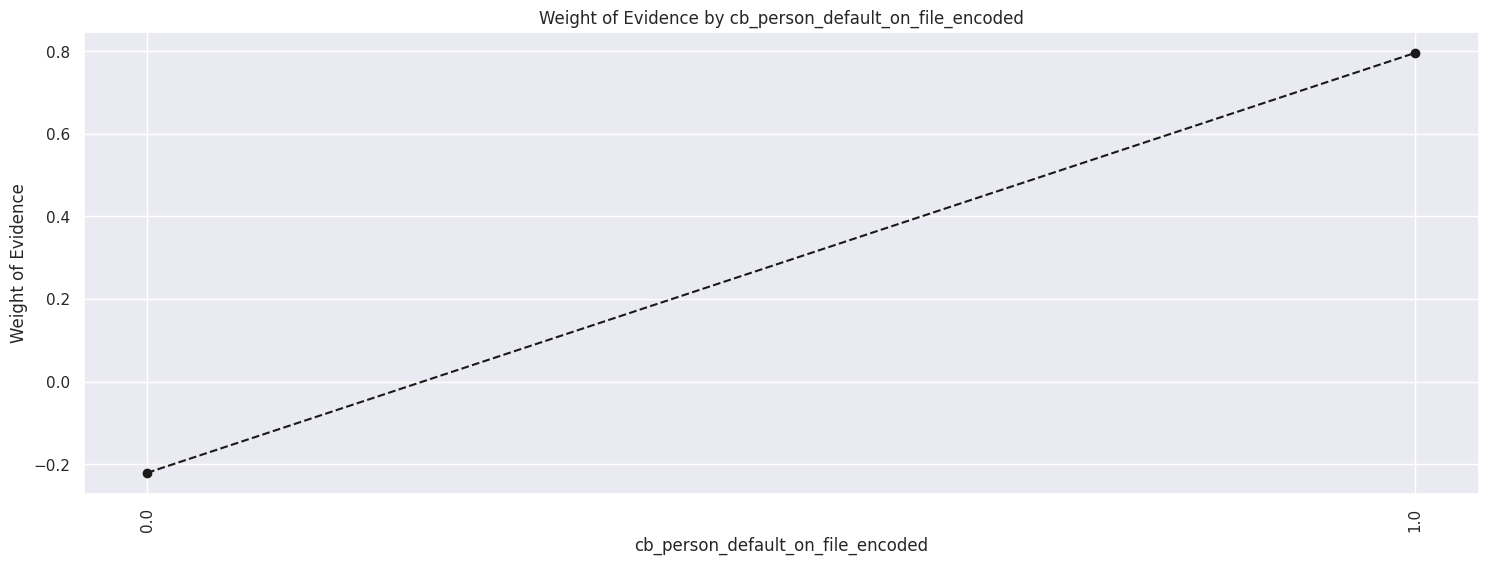

In [ ]:
plot_by_woe(df_temp, 90)

### WoE Binning

In [ ]:
# Crear una lista de todas las categorías de referencia, es decir, una categoría de cada una de las características globales
ref_categories = ['loan_grade:G', 'person_home_ownership:MORTGAGE', 'loan_intent:EDUCATION', 'person_age:52.0-68.0', 'person_income:<163k',
                  'person_emp_length:12.4-18.6', 'loan_amnt:7.4k-14.3k', 'loan_int_rate:8.98-12.54', 'loan_percent_income:0.166-0.332',
                  'cb_person_default_on_file_encoded:0']

# Clase de transformador personalizado para crear nuevas características ficticias categóricas
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):

        X_new = X.loc[:, 'loan_grade:A': 'loan_grade:G']

        X_new['person_home_ownership:OWN'] = X.loc[:,'person_home_ownership:OWN']
        X_new['person_home_ownership:MORTGAGE'] = X.loc[:,'person_home_ownership:MORTGAGE']
        X_new['person_home_ownership:OTHER_RENT'] = sum([X['person_home_ownership:OTHER'], X['person_home_ownership:RENT']])

        X_new['loan_intent:DEBTCONSOLIDATION'] = X.loc[:,'loan_intent:DEBTCONSOLIDATION']
        X_new['loan_intent:EDUCATION'] = X.loc[:,'loan_intent:EDUCATION']
        X_new['loan_intent:HOMEIMPROVEMENT'] = X.loc[:,'loan_intent:HOMEIMPROVEMENT']
        X_new['loan_intent:MEDICAL'] = X.loc[:,'loan_intent:MEDICAL']
        X_new['loan_intent:PERSONAL'] = X.loc[:,'loan_intent:PERSONAL']
        X_new['loan_intent:VENTURE'] = X.loc[:,'loan_intent:VENTURE']

        X_new['person_age:<36.0'] = np.where((X['person_age'] <= 36.0), 1, 0)
        X_new['person_age:36.0-52.0'] = np.where((X['person_age'] > 36.0) & (X['person_age'] <= 52.0), 1, 0)
        X_new['person_age:52.0-68.0'] = np.where((X['person_age'] > 52.0) & (X['person_age'] <= 68.0), 1, 0)
        X_new['person_age:>68.0'] = np.where((X['person_age'] > 68.0), 1, 0)

        X_new['person_income:<163k'] = np.where((X['person_income'] <= 163254.0), 1, 0)
        X_new['person_income:163k-322k'] = np.where((X['person_income'] > 163254.0) & (X['person_income'] <= 322448.0), 1, 0)
        X_new['person_income:322k-482k'] = np.where((X['person_income'] > 322448.0) & (X['person_income'] <= 481632.0), 1, 0)
        X_new['person_income:482k-641k'] = np.where((X['person_income'] > 481632.0) & (X['person_income'] <= 640816.0), 1, 0)
        X_new['person_income:>641k'] = np.where((X['person_income'] > 640816.0), 1, 0)

        X_new['person_emp_length:6.2'] = np.where((X['person_emp_length'] <= 6.2), 1, 0)
        X_new['person_emp_length:6.2-12.4'] = np.where((X['person_emp_length'] > 6.2) & (X['person_emp_length'] <= 12.4), 1, 0)
        X_new['person_emp_length:12.4-18.6'] = np.where((X['person_emp_length'] > 12.4) & (X['person_emp_length'] <= 18.6), 1, 0)
        X_new['person_emp_length:18.6-24.8'] = np.where((X['person_emp_length'] > 18.6) & (X['person_emp_length'] <= 24.8), 1, 0)
        X_new['person_emp_length:>24.8'] = np.where((X['person_emp_length'] > 24.8), 1, 0)

        X_new['loan_amnt:<7.4k'] = np.where((X['loan_amnt'] <= 7400.0), 1, 0)
        X_new['loan_amnt:7.4k-14.3k'] = np.where((X['loan_amnt'] > 7400.0) & (X['loan_amnt'] <= 14300.0), 1, 0)
        X_new['loan_amnt:14.3k-21.2k'] = np.where((X['loan_amnt'] > 14300.0) & (X['loan_amnt'] <= 21200.0), 1, 0)
        X_new['loan_amnt:21.2k-28.1k'] = np.where((X['loan_amnt'] > 21200.0) & (X['loan_amnt'] <= 28100.0), 1, 0)
        X_new['loan_amnt:>28.1k'] = np.where((X['loan_amnt'] > 28100.0), 1, 0)

        X_new['loan_int_rate:<8.98'] = np.where((X['loan_int_rate'] <= 8.98), 1, 0)
        X_new['loan_int_rate:8.98-12.54'] = np.where((X['loan_int_rate'] > 8.98) & (X['loan_int_rate'] <= 12.54), 1, 0)
        X_new['loan_int_rate:12.54-16.1'] = np.where((X['loan_int_rate'] > 12.54) & (X['loan_int_rate'] <= 16.1), 1, 0)
        X_new['loan_int_rate:16.1-19.66'] = np.where((X['loan_int_rate'] > 16.1) & (X['loan_int_rate'] <= 19.66), 1, 0)
        X_new['loan_int_rate:>19.66'] = np.where((X['loan_int_rate'] > 19.66), 1, 0)

        X_new['loan_percent_income:<0.166'] = np.where((X['loan_percent_income'] <= 0.166), 1, 0)
        X_new['loan_percent_income:0.166-0.332'] = np.where((X['loan_percent_income'] > 0.166) & (X['loan_percent_income'] <= 0.332), 1, 0)
        X_new['loan_percent_income:0.332-0.498'] = np.where((X['loan_percent_income'] > 0.332) & (X['loan_percent_income'] <= 0.498), 1, 0)
        X_new['loan_percent_income:0.498-0.664'] = np.where((X['loan_percent_income'] > 0.498) & (X['loan_percent_income'] <= 0.664), 1, 0)
        X_new['loan_percent_income:>0.664'] = np.where((X['loan_percent_income'] > 0.664), 1, 0)

        X_new['cb_person_default_on_file_encoded:0'] = np.where((X['cb_person_default_on_file_encoded'] == 0), 1, 0)
        X_new['cb_person_default_on_file_encoded:1'] = np.where((X['cb_person_default_on_file_encoded'] == 1), 1, 0)

        X_new.drop(columns = ref_categories, inplace = True)
        return X_new


## Entrenamiento del modelo

In [ ]:
# reconfirm shape of the 4 datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22797, 27)
(22797,)
(5700, 27)
(5700,)


In [ ]:
# define modeling pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# define cross-validation criteria
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8648
Gini: 0.7296


In [ ]:
# fit the pipeline on the whole training set
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe',
                 WoE_Binning(X=       person_age  person_income person_home_ownership  person_emp_length  \
0              22          59000                  RENT              123.0   
1              21           9600                   OWN                5.0   
2              25           9600              MORTGAGE                1.0   
3              23          65500                  RENT                4.0   
4              24          54400                  RENT                8.0   
...           ...            ...                   ...                ...   
28492          57          53000              MORTGAGE                1.0   
28493          54         120000              MORTGAGE                4.0   
28494          65          76000                  RENT                3.0   
28495          56         150000              MORTGAGE                5.0   
28496          66          42000                  RENT                2.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate  \
0             PERS...
28495         PERSONAL          B      15000          11.48   
28496          MEDICAL          B       6475           9.99   

       loan_percent_income  cb_person_cred_hist_length  \
0                     0.59                           3   
1                     0.10                           2   
2                     0.57                           3   
3                     0.53                           2   
4                     0.55                           4   
...                    ...                         ...   
28492                 0.11                          30   
28493                 0.15                          19   
28494                 0.46                          28   
28495                 0.10                          26   
28496                 0.15                          30   

       cb_person_default_on_file_encoded  
0                                      1  
1                                      0  
2                                      0  
3                                      0  
4                                      1  
...                                  ...  
28492                                  0  
28493                                  0  
28494                                  0  
28495                                  0  
28496                                  0  

[28497 rows x 11 columns])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
# create a summary table
# first create a transformed training set through our WoE_Binning custom class
X_train_woe_transformed = woe_transform.fit_transform(X_train)
# Store the column names in X_train as a list
feature_name = X_train_woe_transformed.columns.values
# Create a summary table of our logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Create a new column in the dataframe, called 'Coefficients'
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# Increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# Assign our model intercept to this new row
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# Sort the dataframe by index
summary_table.sort_index(inplace = True)
summary_table.head(20)

,Feature name,Coefficients
0,Intercept,1.991146
1,loan_grade:A,-2.844831
2,loan_grade:B,-2.843602
3,loan_grade:C,-2.491754
4,loan_grade:D,-0.375352
5,loan_grade:E,-0.091682
6,loan_grade:F,0.086165
7,person_home_ownership:OWN,-1.610379
8,person_home_ownership:OTHER_RENT,0.818197
9,loan_intent:DEBTCONSOLIDATION,0.609268


## Prediction Time

In [ ]:
# make preditions on our test set
y_hat_test = pipeline.predict(X_test)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test)
# select the probabilities of only the positive class (class 1 - default)
y_hat_test_proba = y_hat_test_proba[:][: , 1]

In [ ]:
# we will now create a new DF with actual classes and the predicted probabilities
# create a temp y_test DF to reset its index to allow proper concaternation with y_hat_test_proba
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(5700, 2)

In [ ]:
# Rename the columns
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head(10)

,y_test_class_actual,y_hat_test_proba
14139,1,0.733242
20866,0,0.151250
10538,1,0.656388
26203,0,0.200600
10529,0,0.791961
14546,0,0.402899
4230,0,0.414604
23904,0,0.097632
20573,0,0.169222
4656,0,0.159025


###Confusion Matrix and AUROC on Test Set

In [ ]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.64070175, 0.14210526],
       [0.06105263, 0.15614035]])

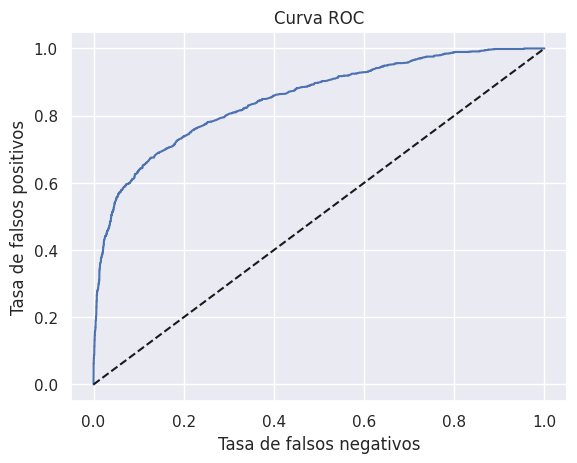

In [ ]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('Tasa de falsos negativos')
plt.ylabel('Tasa de falsos positivos')
plt.title('Curva ROC');

AUROC: 0.8648
Gini: 0.7296


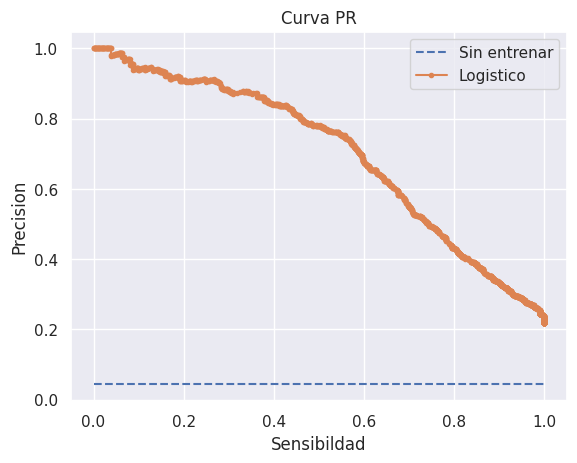

In [ ]:

# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
# print AUROC and Gini
print('AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (Gini))

# draw a PR curve
# calculate the no skill line as the proportion of the positive class
no_skill = len(y_test[y_test == 1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Sin entrenar')
# get the values required to plot a PR curve
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'],
                                                       y_test_proba['y_hat_test_proba'])
# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistico')
plt.xlabel('Sensibildad')
plt.ylabel('Precision')
plt.legend()
plt.title('Curva PR');

## Scorecard Development

In [ ]:
# create a new dataframe with one column with values from the 'reference_categories' list
df_ref_categories = pd.DataFrame(ref_categories, columns = ['Feature name'])
# We create a second column, called 'Coefficients', which contains only 0 values.
df_ref_categories['Coefficients'] = 0

# Concatenates two dataframes
df_scorecard = pd.concat([summary_table, df_ref_categories])
# reset the index
df_scorecard.reset_index(inplace = True)

# create a new column, called 'Original feature name', which contains the value of the 'Feature name' column
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

# Define the min and max threshholds for our scorecard
min_score = 300
max_score = 850

# calculate the sum of the minimum coefficients of each category within the original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients of each category within the original feature name
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()
# create a new column that has the imputed calculated Score based scaled from the coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (
	max_sum_coef - min_sum_coef)
# update the calculated score of the Intercept
df_scorecard.loc[0, 'Score - Calculation'] = (
	(df_scorecard.loc[0,'Coefficients'] - min_sum_coef) /
	(max_sum_coef - min_sum_coef
	)) * (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' column and store them in a new column
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

# check the min and max possible scores of our scorecard
min_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = df_scorecard.groupby('Original feature name')['Score - Preliminary'].max().sum()
print(min_sum_score_prel)
print(max_sum_score_prel)
# look like we can get by deducting 1 from the Intercept
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598
df_scorecard

301.0
850.0


,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,1.991146,Intercept,607.579794,608.0,598.0
1,1,loan_grade:A,-2.844831,loan_grade,-95.917630,-96.0,-96.0
2,2,loan_grade:B,-2.843602,loan_grade,-95.876177,-96.0,-96.0
3,3,loan_grade:C,-2.491754,loan_grade,-84.013128,-84.0,-84.0
4,4,loan_grade:D,-0.375352,loan_grade,-12.655531,-13.0,-13.0
5,5,loan_grade:E,-0.091682,loan_grade,-3.091191,-3.0,-3.0
6,6,loan_grade:F,0.086165,loan_grade,2.905190,3.0,3.0
7,7,person_home_ownership:OWN,-1.610379,person_home_ownership,-54.296285,-54.0,-54.0
8,8,person_home_ownership:OTHER_RENT,0.818197,person_home_ownership,27.586691,28.0,28.0
9,9,loan_intent:DEBTCONSOLIDATION,0.609268,loan_intent,20.542353,21.0,21.0


Quitamos los que no aportan al modelo

In [ ]:
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,1.991146,Intercept,607.579794,608.0,598.0
1,1,loan_grade:A,-2.844831,loan_grade,-95.917630,-96.0,-96.0
2,2,loan_grade:B,-2.843602,loan_grade,-95.876177,-96.0,-96.0
3,3,loan_grade:C,-2.491754,loan_grade,-84.013128,-84.0,-84.0
4,4,loan_grade:D,-0.375352,loan_grade,-12.655531,-13.0,-13.0
5,5,loan_grade:E,-0.091682,loan_grade,-3.091191,-3.0,-3.0
6,6,loan_grade:F,0.086165,loan_grade,2.905190,3.0,3.0
7,7,person_home_ownership:OWN,-1.610379,person_home_ownership,-54.296285,-54.0,-54.0
8,8,person_home_ownership:OTHER_RENT,0.818197,person_home_ownership,27.586691,28.0,28.0
9,9,loan_intent:DEBTCONSOLIDATION,0.609268,loan_intent,20.542353,21.0,21.0


In [ ]:
df_scorecard = df_scorecard[:-10]
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Score - Final
0,0,Intercept,1.991146,Intercept,607.579794,608.0,598.0
1,1,loan_grade:A,-2.844831,loan_grade,-95.917630,-96.0,-96.0
2,2,loan_grade:B,-2.843602,loan_grade,-95.876177,-96.0,-96.0
3,3,loan_grade:C,-2.491754,loan_grade,-84.013128,-84.0,-84.0
4,4,loan_grade:D,-0.375352,loan_grade,-12.655531,-13.0,-13.0
5,5,loan_grade:E,-0.091682,loan_grade,-3.091191,-3.0,-3.0
6,6,loan_grade:F,0.086165,loan_grade,2.905190,3.0,3.0
7,7,person_home_ownership:OWN,-1.610379,person_home_ownership,-54.296285,-54.0,-54.0
8,8,person_home_ownership:OTHER_RENT,0.818197,person_home_ownership,27.586691,28.0,28.0
9,9,loan_intent:DEBTCONSOLIDATION,0.609268,loan_intent,20.542353,21.0,21.0


In [ ]:
x= list(df_scorecard['Feature name'])
np.savetxt("variables.csv", x, delimiter =",",fmt ='% s')

### Calculo de los puntajes para todas las observaciones en los datos de prueba

In [ ]:
# first create a transformed test set through our WoE_Binning custom class
X_test_woe_transformed = woe_transform.fit_transform(X_test)
# insert an Intercept column in its beginning to align with the # of rows in scorecard
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.head()

,Intercept,loan_grade:A,loan_grade:B,loan_grade:C,loan_grade:D,loan_grade:E,loan_grade:F,person_home_ownership:OWN,person_home_ownership:OTHER_RENT,loan_intent:DEBTCONSOLIDATION,...,loan_amnt:>28.1k,loan_int_rate:<8.98,loan_int_rate:12.54-16.1,loan_int_rate:16.1-19.66,loan_int_rate:>19.66,loan_percent_income:<0.166,loan_percent_income:0.332-0.498,loan_percent_income:0.498-0.664,loan_percent_income:>0.664,cb_person_default_on_file_encoded:1
14139,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
20866,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
10538,1,0,0,1,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
26203,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
10529,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [ ]:
# get the list of our final scorecard scores
scorecard_scores = df_scorecard['Score - Final']
# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(5700, 38)
(38,)


In [ ]:
# we can see that the test set has 17 less columns than the rows in scorecard due to the reference categories
# since the reference categories will always be scored as 0 based on the scorecard, it is safe to add these categories to the end of test set with 0 values
X_test_woe_transformed = pd.concat([X_test_woe_transformed, pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)),
                                                                         index = X_test_woe_transformed.index)], axis = 1)
# Need to reshape scorecard_scores so that it is (102,1) to allow for matrix dot multiplication
scorecard_scores = scorecard_scores.values.reshape(38, -1)
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(5700, 48)
(38, 1)


In [ ]:
X_test_woe_transformed=X_test_woe_transformed.drop(['loan_grade:G', 'person_home_ownership:MORTGAGE', 'loan_intent:EDUCATION', 'person_age:52.0-68.0', 'person_income:<163k',
                                  'person_emp_length:12.4-18.6', 'loan_amnt:7.4k-14.3k', 'loan_int_rate:8.98-12.54',
                                  'loan_percent_income:0.166-0.332', 'cb_person_default_on_file_encoded:0'], axis=1)

In [ ]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.head()

,0
14139,564.0
20866,473.0
10538,554.0
26203,485.0
10529,576.0


In [ ]:
#Guardamos estos valores para hacer la implementacion del sitio web
scorecard_scores.tofile('Data.csv', sep = ',')
len(scorecard_scores)

38

### Fijación de los límites de aprobación de los préstamos

In [ ]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

Best Threshold: 0.167051


Esto significa que, basándose en el estadístico J de Youden, el umbral de probabilidad ideal es 0.167051, que minimiza el FPR y maximiza el TPR: todas las muestras con una probabilidad predicha superior a este valor deberían clasificarse como en Default y viceversa.

In [ ]:

# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) *
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

# define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold.
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']

# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.360324, 0.360326)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate


## Comportamiento de la población

<ipython-input-86-d70b33ffcae5>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_scores)


<Axes: ylabel='Density'>

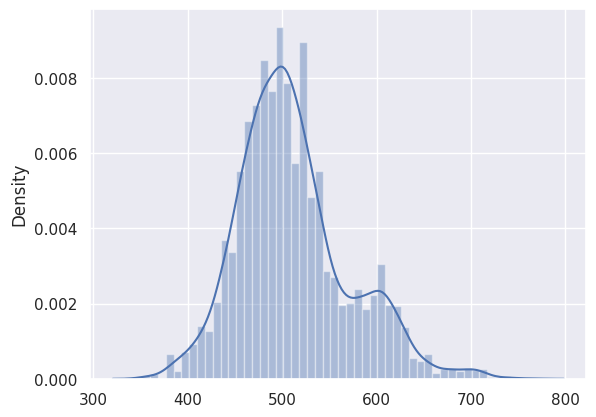

In [ ]:
sns.distplot(y_scores)

In [ ]:
!pip install distfit
from distfit import distfit

# Initialize distfit
dist = distfit()

# Determine best-fitting probability distribution for data
dist.fit_transform(np.array(y_scores))
print(dist.summary)

  Obtaining dependency information for distfit from https://files.pythonhosted.org/packages/40/f5/2d346512de1e9c781b66251dbf4c8b0cd6a37f09af2828eec7f457fd9e25/distfit-1.6.11-py3-none-any.whl.metadata
  Obtaining dependency information for colourmap>=1.1.10 from https://files.pythonhosted.org/packages/05/37/10bb10d990a6c986d25c5c7407ad740ee0cf047a6a0a1f297b0b92e3caaf/colourmap-1.1.16-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 1.6 MB/s eta 0:00:00


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 7.35313e-05] [loc=511.278 scale=58.631]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.00050214] [loc=352.000 scale=159.278]
[distfit] >INFO> [pareto    ] [0.01 sec] [RSS: 0.00050214] [loc=-34359738016.000 scale=34359738368.000]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 4.50633e-05] [loc=505.533 scale=46.454]
[distfit] >INFO> [t         ] [0.52 sec] [RSS: 7.35304e-05] [loc=511.278 scale=58.631]
[distfit] >INFO> [genextreme] [0.40 sec] [RSS: 4.08323e-05] [loc=486.606 scale=51.124]
[distfit] >INFO> [gamma     ] [0.04 sec] [RSS: 4.48368e-05] [loc=301.114 scale=16.047]
[distfit] >INFO> [lognorm   ] [0.01 sec] [RSS: 4.19324e-05] [loc=230.745 scale=274.648]
[distfit] >INFO> [beta      ] [0.25 sec] [RSS: 4.49621e-05] [loc=302.609 scale=18843.541]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.000420877] [loc=352.000 scale=415.000]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 7.55525e-05] 

          name     score            loc               scale  \
0   genextreme  0.000041     486.606451           51.123948   
1      lognorm  0.000042     230.744691          274.648326   
2        gamma  0.000045     301.114158           16.047183   
3         beta  0.000045     302.608719        18843.541392   
4     dweibull  0.000045     505.533281            46.45412   
5            t  0.000074     511.278243            58.63059   
6         norm  0.000074     511.278421           58.630917   
7     loggamma  0.000076  -17175.385811         2389.454658   
8      uniform  0.000421          352.0               415.0   
9       pareto  0.000502 -34359738016.0  34359738367.999996   
10       expon  0.000502          352.0          159.278421   

                                        arg  \
0                    (0.10198964636660521,)   
1                     (0.2056291732426482,)   
2                     (13.096645557226802,)   
3   (12.76196073745551, 1139.6459785538214)   
4       

In [ ]:
print("Puntuacion Minima:", y_scores.min(), "Puntuacion Maxima:", y_scores.max())

Puntuacion Minima: 0    352.0
dtype: float64 Puntuacion Maxima: 0    767.0
dtype: float64


In [ ]:
def percentil(score):
  per = score/973*100
  return (per)

percentil(y_scores)

,0
14139,57.965057
20866,48.612539
10538,56.937307
26203,49.845838
10529,59.198356
...,...
7992,52.209661
5093,62.384378
5338,59.301131
13562,59.917780


In [ ]:
y_scores.min()

0    352.0
dtype: float64